In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

In [138]:
def make_toy_batch(batchsize=2):
    img = torch.zeros(batchsize, 1, 256, 256)
    mask = torch.zeros_like(img)
    for b in range(batchsize):
        x = torch.randint(32, 255-32, [])
        y = torch.randint(32, 255-32, [])

        mask[b,:,y-16:y+16,x-16:x+16] = 1
        img[b,:,y-16:y+16,x-16:x+16] = torch.rand(1,1,32,32) > 0.8
    
    return img, mask

In [139]:
def marching_cubes(coarse):
    coarse_class = coarse > 0
    NW = coarse_class[:,:,:-1,:-1]
    NE = coarse_class[:,:,:-1,1:]
    SW = coarse_class[:,:,1:,:-1]
    SE = coarse_class[:,:,1:,1:]

    cells = torch.stack([NW, NE, SW, SE], dim=-1)
    cellsum = cells.sum(dim=-1)
    interest_mask = (cellsum > 0) * (cellsum < 4)
    print(cellsum.sum())
    plt.imshow(interest_mask[0,0])

class SnakeNet(nn.Module):
    def __init__(self, input_channels, output_channels, base_channels=16):
        super().__init__()
        bc = base_channels

        # Backbone
        self.backbone = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, 2, stride=2),
            nn.Conv2d(1 * bc, 2 * bc, 2, stride=2), nn.Tanh(),
            nn.Conv2d(2 * bc, 4 * bc, 2, stride=2), nn.Tanh(),
            nn.Conv2d(4 * bc, 8 * bc, 2, stride=2), nn.Tanh(),
        )
        
        self.make_coarse = nn.Conv2d(8 * bc, 1, 1)

    def forward(self, x):
        features = self.backbone(x)
        coarse = self.make_coarse(features)

        # Do Marching squares
        x = features

        return x, coarse

In [144]:
net = SnakeNet(1, 1)
opt = torch.optim.Adam(net.parameters(), 1e-3)

for i in range(100):
    img, mask = make_toy_batch()
    N, C, H, W = img.shape
    coarse_target = mask.view(N, C, H // 16, 16, W // 16, 16)
    coarse_target = coarse_target.transpose(3, 4)
    coarse_target = coarse_target.reshape(N, C, H // 16, W // 16, -1)
    coarse_target = coarse_target.max(dim=-1)[0]
    x, coarse = net(img)

    coarse_loss = F.binary_cross_entropy_with_logits(coarse, coarse_target)
    opt.zero_grad()
    coarse_loss.backward()
    opt.step()
    if i % 10 == 10-1:
        print(coarse_loss.item())

print(img.shape, '->', coarse.shape)

0.1560410112142563
0.1834889054298401
0.14803507924079895
0.1466134935617447
0.10694143176078796
0.1321132481098175
0.08916190266609192
0.0635504424571991
0.045418158173561096
0.046652719378471375
torch.Size([2, 1, 256, 256]) -> torch.Size([2, 1, 16, 16])


tensor(40)


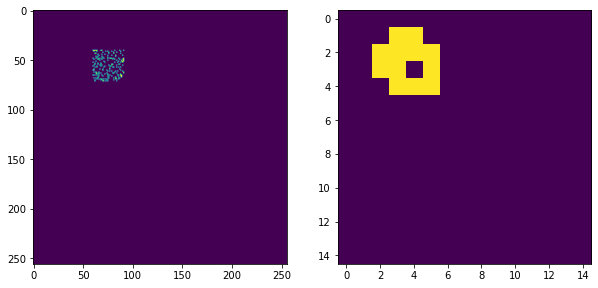

In [146]:
plt.subplot(1, 2, 1)
plt.imshow(img[0,0])
plt.subplot(1, 2, 2)
marching_cubes(coarse)

tensor(167) tensor(90)


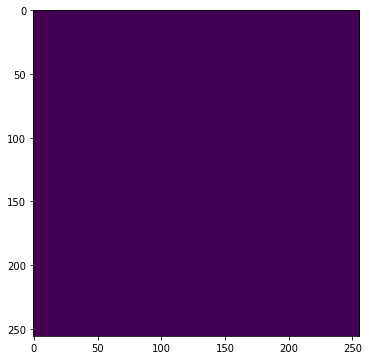

In [70]:
plt.imshow(make_toy_example()[0,0])

tensor(163) tensor(80)


tensor(0.)